Planetary Structure Solver

This module calculates density and pressure profiles inside a planet based on a list of radii and a dictionary describing its layered composition. The solver uses different equations of state (EoS) for various planetary layers such as the core, mantle, and ice layer.

Notebook Instructions:
1. Define the planetary composition:
   Use the `planetary_dictionary()` function to create a dictionary that describes the planetary composition. The dictionary takes the following inputs:
   - `planet_size`: The radius of the planet in Earth radii (e.g., 1 for Earth-sized planet).
   - `iron_part`: The fractional depth of the iron core (e.g., 0.3 for 30% core).
   - `rock_part`: The fractional depth of the rock mantle (e.g., 0.5 for 50% mantle).

   Example: `dct.planetary_dictionary(1, 0.3, 0.5)` creates a planet with:
   - A core that is 30% of the planet’s radius.
   - A mantle that is 50% of the planet’s radius.

2. Define the radius input:
   Use the `radii_list` to specify the radii at which density and pressure should be evaluated. A recommended format is `[*range(1, int(r_planet), int(r_planet / slices))]`, where `r_planet` is the planet radius (in meters) and `slices` is the number of radial slices you want.

3. Run the Solver:
   Call the `Solver()` function to compute the density and pressure profiles of the planet.
   - Input: `radii_list` (list of radii in meters), `insert_dict` (planet composition dictionary).
   - Output: Two lists: one for densities (in kg/m³) and one for pressures (in Pa).

4. Visualize results:
   Use the `plotter()` function to visualize the density or pressure profile as a function of radius. You can plot either:
   - `'density'` for density profile.
   - `'pressure'` for pressure profile.

   Example:
   - To plot density: `plotter(radii_list, dct.planetary_dictionary(1, 0.3, 0.5), 'density')`
   - To plot pressure: `plotter(radii_list, dct.planetary_dictionary(1, 0.3, 0.5), 'pressure')`

Note:
- The largest radius in radii_list must match planet_size (converted to meters).
- All computations use SI units.

In [2]:
import EoS_Bits as EOS
import planetary_dictionary as dct
import solve_adams_williamson as aw

import numpy as np
from matplotlib import pyplot as plt

r_earth = 6370 * (10 ** 3)


def Solver(radii_list, insert_dict, density_list = [], discrepancy = 10, calls = 0):
    '''
    Computes the self-consistent radial density and pressure profiles of a planet given a list of radii 
    and a planetary composition dictionary.

    Parameters:
    radii_list (list): A list of radial distances from the center of the planet (in meters) at which density and pressure will be calculated.
    insert_dict (dict): A dictionary specifying the planet's compositional layers. Can be created using planetary_dictionary() or manually.
    density_list (list, optional): An optional list of initial density values as guesses (eg: zero-pressure densities). Defaults to an empty list.
    discrepancy (float, optional): The convergence threshold for density in kg/m^3. Defaults to 10.
    calls (int, optional): Recursion counter to prevent infinite loops. Defaults to 0.

    Returns:
        tuple: A tuple containing two lists:
            - List of densities at each radius (in kg/m^3)
            - List of pressures at each radius (in Pa)
    '''
#The density list is initially empty and is populated after the first run.
#The discrepancy represents the error in density.
    """
    Requires importing EoS_Bits as EOS, planetary_dictionary as dct, solve_adams_williamson as aw
    
    Parameters:
    1) radii_list
    2) planetary dictionary
    3) density_list (optional, preferred to leave empty)
    4) discrepancy (10 by default)
    5) calls (leave as 0; do not change)
    
    """

    pressure_n = {}
    pressure_n1 = {}
    density_n1 = {}
    calls += 1


    while calls <= 2000:
    #Prevents the number of recursions from diverging.
        if int(max([*insert_dict.keys()])) != int(max(radii_list)):            
            insert_dict[int(float(f"{int(max(radii_list))}"))] = insert_dict.pop(int(float(f'{max([*insert_dict.keys()])}')))
            return(Solver(radii_list, insert_dict, density_list = [], discrepancy = discrepancy, calls = 0))
        #Ensures that the maximum radius in the planet's dictionary and the radius list are compatible

        
        if len(density_list) == 0:
            for count in range(len(radii_list)):
                for cutoff in [*insert_dict.keys()]:
                        if radii_list[count] <= cutoff:
                            if count == len(density_list):
                                density_list.append(int(insert_dict[cutoff][0]))
        #On the first iteration, the Solver makes a density_list using initial density guesses as preliminary values
    
        pressure_list = aw.adams_williamson(radii_list, density_list)
        #pressure_list is a list of initial pressures at each radius.
        
        for n in radii_list:
            pressure_n[n] = pressure_list[n][1]
        #At each radius in the list, a corresponding pressure is assigned. This is the nth pressure.
        
        for n in radii_list:
            nth_p_n = pressure_n[n]
            #This assigns the pressure at the nth radius calculated for the nth time.
            for cutoff in list(insert_dict.keys()):    
                if n <= cutoff: 
                #Here, we select the correct EoS and EoS parameters corresponding that layer's radius, pressure, and material.
                    
                    if list(insert_dict.keys()).index(cutoff) == 0:
                    #This "if block" is for calculations within the Core.
                        
                        #We calculate the n+1th density and pressure using functions from EoS_Bits 
                    
                        density_n1[n] = EOS.CoreDensity(nth_p_n)
                        pressure_n1[n] = EOS.Vinet(density_n1[n],7678,136.2 * (10 ** 9),5.97)
                        break
                        
                    elif list(insert_dict.keys()).index(cutoff) == 1:
                    #This "if block" is for calculations within the Mantle.
                        
                        #We calculate the n+1th density and pressure using functions from EoS_Bits 
                        
                        density_n1[n] = EOS.RockDensity(nth_p_n)
                        
                        #Depending on the pressure, different EOS parameters are selected.
                        if nth_p_n < 2.5 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n], 3221,125 * (10 ** 9),4) + 0.299 * EOS.BM3(density_n1[n],2648,37.4 * (10 ** 9),6.2)
                            break
                        elif nth_p_n < 8 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n], 3221,125 * (10 ** 9),4) + 0.299 * EOS.BM3(density_n1[n],2921,96 * (10 ** 9),8.4)
                            break
                        elif nth_p_n < 14 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n], 3221,125 * (10 ** 9),4) + 0.299 * EOS.BM3(density_n1[n],4290,309.9 * (10 ** 9),4.59)
                            break
                        elif nth_p_n < 18 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n],3491,160 * (10 ** 9),4) + 0.299 * EOS.BM3(density_n1[n],4290,309.9 * (10 ** 9),4.59)
                            break
                        elif nth_p_n < 23 * (10 ** 9):
                            pressure_n1[n] = 0.701 * EOS.BM3(density_n1[n],3548,182 * (10 ** 9),4.2) + 0.299 * EOS.BM3(density_n1[n],4290,309.9 * (10 ** 9),4.59)
                            break
                        elif nth_p_n < 120 * (10 ** 9):
                            pressure_n1[n] = EOS.BM3(density_n1[n], 4101,256 * (10 ** 9),4)
                            break
                        else:
                            pressure_n1[n] = EOS.Vinet(density_n1[n], 4058,221 * (10 ** 9),4.2)
                            break
                        
                    elif list(insert_dict.keys()).index(cutoff) == 2:
                    #This "if block" is for calculations within the Ice.
                        
                        #We calculate the n+1th density and pressure using functions from EoS_Bits 
                        density_n1[n] = EOS.IceDensity(nth_p_n)
                        
                        if nth_p_n < 1 * (10 ** 9):
                            pressure_n1[n] = EOS.Murnaghan(density_n1[n], 930, 9.85 * (10 ** 9), 6.6)
                            break
                        elif nth_p_n < 2.1 * (10 ** 9):
                            pressure_n1[n] = EOS.BM3(density_n1[n], 1271, 14.05 * (10 ** 9), 4)
                            break
                        else:
                            pressure_n1[n] = EOS.BM3(density_n1[n], 1456, 14.9 * (10 ** 9), 5.4)
                            break
    
        if all(abs(np.array(list(density_n1.values())[:1000]) - np.array(density_list[:1000]) < discrepancy)):
            return(list(density_n1.values()), list(pressure_n1.values()))
        #If all densities are self-consistent to 10 kg/m^3, return a list of densities and a list of pressures.
    
        else:
            return(Solver(radii_list, insert_dict, density_list = list(density_n1.values()), discrepancy = discrepancy, calls = calls))
        #If densities are not yet self-consistent, reiterate the process.
        
    return([0], [0])
    #If densities do not converge, then return empty lists.

Let's try creating a planet using ```planetary_dictionary``` and running our Solver to print out our densities and pressures.

Let's construct a planet that has a radius of 1 Earth radius. It will be 0.3 parts core and 0.5 parts mantle by depth.

In [23]:
print('Our dictionary:')
print(dct.planetary_dictionary(1, 0.3, 0.5))
print('\n')

print('Our densities and pressures:')
print(Solver([*range(1, int(r_earth), int(r_earth / 1000))], dct.planetary_dictionary(1, 0.3, 0.5)))
#print(len(Solver([*range(1, int(r_earth), int(r_earth / 1000))], dct.planetary_dictionary(1, 0.3, 0.5))))

Our dictionary:
{1911000: [7678], 5096000: [3000], 6370000: [930]}


Our densities and pressures:
([11458.203546593555, 11458.145124625898, 11458.072094525542, 11457.981212175568, 11457.8716659776, 11457.743130863233, 11457.595443874714, 11457.428511466134, 11457.242274735974, 11457.036693976857, 11456.811740948073, 11456.567394662336, 11456.303638926263, 11456.020460827174, 11455.71784976208, 11455.395796786936, 11455.054294172322, 11454.693335088745, 11454.312913377638, 11453.913023385718, 11453.493659838015, 11453.05481774282, 11452.59649231677, 11452.11867892773, 11451.621373048241, 11451.104570218995, 11450.568266018858, 11450.012456040633, 11449.437135871332, 11448.842301075198, 11448.22794718044, 11447.594069666553, 11446.940663955891, 11446.267725403846, 11445.57524929235, 11444.863230824121, 11444.131665115943, 11443.3805471953, 11442.609871995592, 11441.819634352261, 11441.00982900042, 11440.18045057149, 11439.331493590307, 11438.462952473434, 11437.574821526796, 11436.667094

The dictionary has three keys. Each key represents the boundary at which materials change. In other words, our core has a radius of Key 1 meters. Our mantle begins at the edge of our core and extends to Key 2 meters. Our ice layer begins at the edge of the mantle and extends to Key 3 meters.

Our list of densities and pressures both start at the innermost radius and end with the outermost radius specified in our ```radii_list```.

Now, let's plot our density and/or pressure as a function of radius.

In [9]:
def plotter(radii_list, insert_dict, density_or_pressure):
    if density_or_pressure.lower() == "density":
        to_plot = Solver(radii_list, insert_dict)[0]
    elif density_or_pressure.lower() == "pressure":
        to_plot = Solver(radii_list, insert_dict)[1]
    plt.plot(radii_list, to_plot)
    plt.show()

Call the ```plotter``` function with three arguments.

The first argument is our list of radii. In the following example, our list of radii runs from ```1``` to ```1 * 6.371 * (10 ** 6)``` in increments of ```6371``` (a thousand slices for an Earth-sized planet).

The second argument specifies the planet's profile. We use a planetary dictionary here.

The third argument is a string specifying either ```'density'``` or ```'pressure'``` to be plotted.

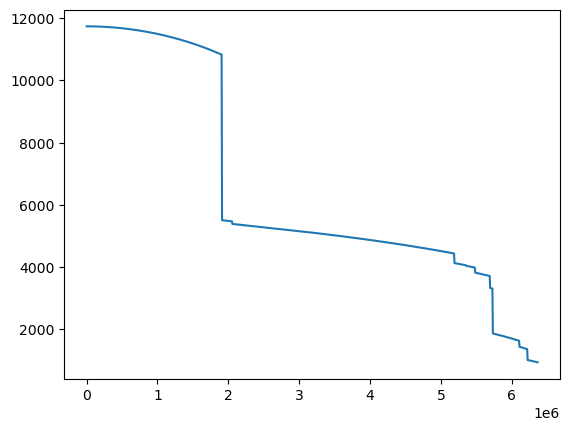

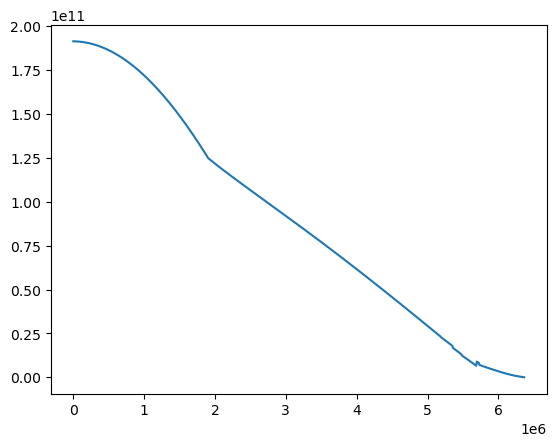

In [10]:
plotter([*range(1, int(r_earth), int(r_earth / 1000))], dct.planetary_dictionary(1, 0.3, 0.6), 'density')
plotter([*range(1, int(r_earth), int(r_earth / 1000))], dct.planetary_dictionary(1, 0.3, 0.6), 'pressure')